In [1]:
using ForneyLab
using ForneyLab: prod!, averageEnergy, differentialEntropy, momentMatch, ruleVBGaussianMeanPrecisionM, ruleVBGaussianMeanPrecisionW
using Plots
using Random
Random.seed!(1);

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have Flux in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading Flux into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [2]:
# Prior distributions
p_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0, v=1)
p_z = ProbabilityDistribution(Univariate, Gamma, a=2.5, b=1)

# Observation
p_y = ProbabilityDistribution(Univariate, PointMass, m=17.5)
;

In [3]:
# Average energy for GaussianMeanPrecision likelihood node
avE(marg_out, marg_mean, marg_prec) = averageEnergy(GaussianMeanPrecision, marg_out, marg_mean, marg_prec)

# Variational distributions parameterized with variational distriubtion parameters
q_x(m,v) = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m, v=v)
q_z(a,b) = ProbabilityDistribution(Univariate, Gamma, a=a, b=b)

# Average energy parameterized with variational distribution parameters
avE(m,v,a,b) = avE(p_y, q_x(m,v), q_z(a,b))

# Free energy as a function of variational distribution parameters
FE(m,v,a,b) = - differentialEntropy(q_x(m,v)) - differentialEntropy(q_z(a,b)) + 
              averageEnergy(GaussianMeanVariance,q_x(m,v),ProbabilityDistribution(Univariate, PointMass, m=0), ProbabilityDistribution(Univariate, PointMass, m=1)) +  
              averageEnergy(Gamma,q_z(a,b),ProbabilityDistribution(Univariate, PointMass, m=2.5), ProbabilityDistribution(Univariate, PointMass, m=1)) +
              avE(m,v,a,b)
;

Let us initialize $q_x$ and $q_z$ with prior distributions $p_x$ and $p_z$.

In [7]:
# Let us keep track how the variational distributions evolve over VMP iterations
qx_list = [p_x]
qz_list = [p_z]
;

In [8]:
# Run VMP for 8 steps
for i=1:4
    # Calculate q(x)
    qz = qz_list[end]
    m_x = ruleVBGaussianMeanPrecisionM(p_y,Any,qz).dist # VMP message towards x
    qx = prod!(p_x,m_x) # Message collision
    push!(qx_list, qx)
    # Calculate q(z)
    qx = qx_list[end]
    m_z = ruleVBGaussianMeanPrecisionW(p_y,qx,Any).dist # VMP message towards z
    qz = prod!(p_z,m_z) # Message collision
    push!(qz_list, qz)
end

In [9]:
qx_list

5-element Array{ProbabilityDistribution{Univariate,GaussianMeanVariance},1}:
 𝒩(m=0, v=1)

 𝒩(m=12.50, v=0.29)

 𝒩(m=3.15, v=0.82)

 𝒩(m=0.49, v=0.97)

 𝒩(m=0.35, v=0.98)


In [10]:
qz_list

5-element Array{ProbabilityDistribution{Univariate,Gamma},1}:
 Gam(a=2.50, b=1)

 Gam(a=3.00, b=13.64)

 Gam(a=3.00, b=1.04e+02)

 Gam(a=3.00, b=1.46e+02)

 Gam(a=3.00, b=1.49e+02)


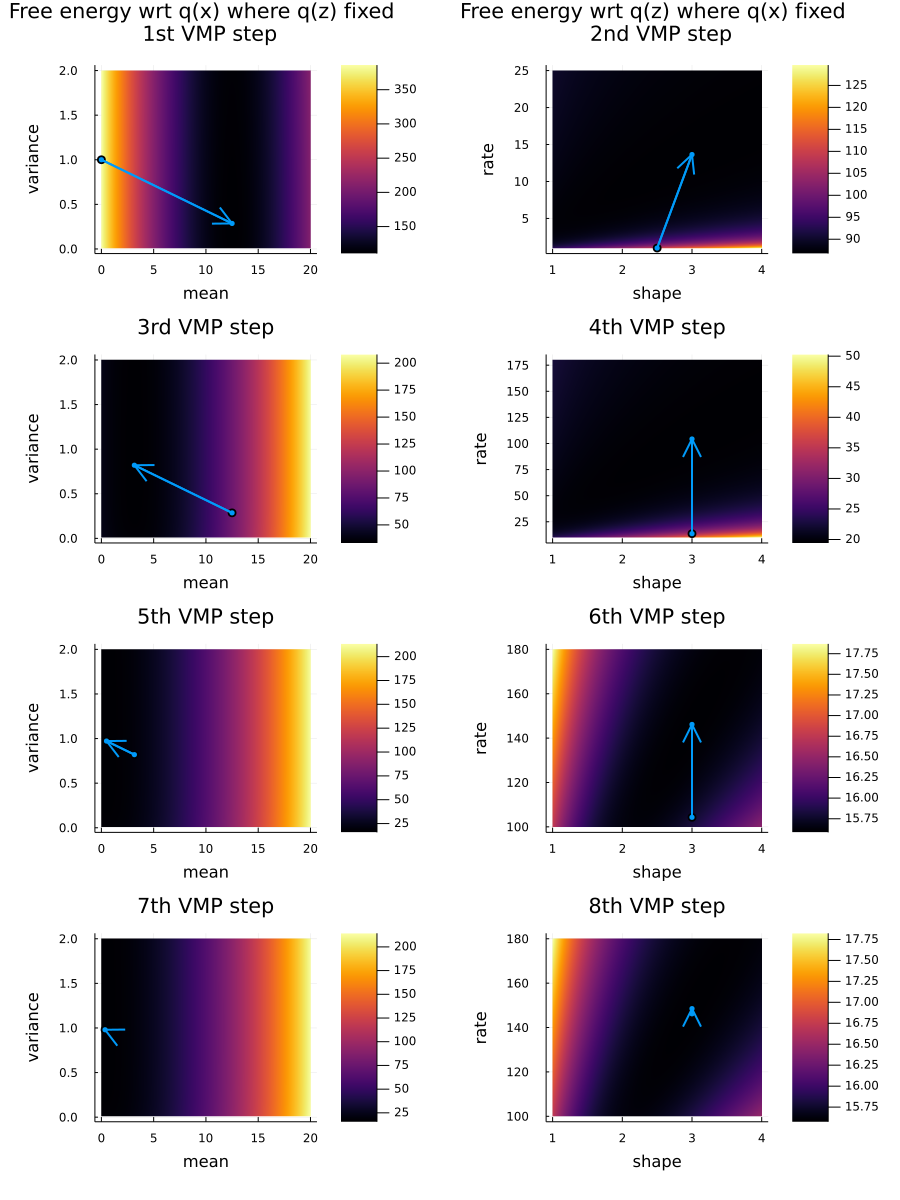

In [31]:
# Plot

# 1st VMP step
m_range = range(0, 20, length=500)
v_range = range(0.01, 2, length=500)
F = [FE(m,v,qz_list[1].params[:a],qz_list[1].params[:b]) for v in v_range, m in m_range]
p1 = heatmap(m_range, v_range, F, xlabel="mean", ylabel="variance", title="Free energy wrt q(x) where q(z) fixed \n 1st VMP step")
scatter!(p1,[mean(qx_list[1]),mean(qx_list[2])],[var(qx_list[1]),var(qx_list[2])],c=1, legend=false)
plot!(p1,[mean(qx_list[1]),mean(qx_list[2])],[var(qx_list[1]),var(qx_list[2])],arrow=true,c=1,linewidth=2,legend=false, top_margin = 2Plots.mm)

# 2nd VMP step
a_range = range(1, 4, length=500)
b_range = range(1, 25, length=500)
F = [FE(mean(qx_list[2]),var(qx_list[2]),a,b) for b in b_range, a in a_range]
p2 = heatmap(a_range, b_range, F, xlabel="shape", ylabel="rate", title="Free energy wrt q(z) where q(x) fixed \n 2nd VMP step")
scatter!(p2,[qz_list[1].params[:a],qz_list[2].params[:a]],[qz_list[1].params[:b],qz_list[2].params[:b]],c=1, legend=false)
plot!(p2,[qz_list[1].params[:a],qz_list[2].params[:a]],[qz_list[1].params[:b],qz_list[2].params[:b]],arrow=true,c=1,linewidth=2,legend=false, top_margin = 2Plots.mm)

# 3rd VMP step
m_range = range(0, 20, length=500)
v_range = range(0.01, 2, length=500)
F = [FE(m,v,qz_list[2].params[:a],qz_list[2].params[:b]) for v in v_range, m in m_range]
p3 = heatmap(m_range, v_range, F, xlabel="mean", ylabel="variance", title="3rd VMP step")
scatter!(p3,[mean(qx_list[2]),mean(qx_list[3])],[var(qx_list[2]),var(qx_list[3])],c=1, legend=false)
plot!(p3,[mean(qx_list[2]),mean(qx_list[3])],[var(qx_list[2]),var(qx_list[3])],arrow=true,c=1,linewidth=2,legend=false)

# 4th VMP step
a_range = range(1, 4, length=500)
b_range = range(10, 180, length=500)
F = [FE(mean(qx_list[3]),var(qx_list[3]),a,b) for b in b_range, a in a_range]
p4 = heatmap(a_range, b_range, F, xlabel="shape", ylabel="rate", title="4th VMP step")
scatter!(p4,[qz_list[2].params[:a],qz_list[3].params[:a]],[qz_list[2].params[:b],qz_list[3].params[:b]],c=1, legend=false)
plot!(p4,[qz_list[2].params[:a],qz_list[3].params[:a]],[qz_list[2].params[:b],qz_list[3].params[:b]],arrow=true,c=1,linewidth=2,legend=false)

# 5th VMP step
m_range = range(0, 20, length=500)
v_range = range(0.01, 2, length=500)
F = [FE(m,v,qz_list[3].params[:a],qz_list[3].params[:b]) for v in v_range, m in m_range]
p5 = heatmap(m_range, v_range, F, xlabel="mean", ylabel="variance", title="5th VMP step")
scatter!(p5,[mean(qx_list[3]),mean(qx_list[4])],[var(qx_list[3]),var(qx_list[4])],c=1, legend=false)
plot!(p5,[mean(qx_list[3]),mean(qx_list[4])],[var(qx_list[3]),var(qx_list[4])],arrow=true,c=1,linewidth=2,legend=false)

# 6th VMP step
a_range = range(1, 4, length=500)
b_range = range(100, 180, length=500)
F = [FE(mean(qx_list[4]),var(qx_list[4]),a,b) for b in b_range, a in a_range]
p6 = heatmap(a_range, b_range, F, xlabel="shape", ylabel="rate", title="6th VMP step")
scatter!(p6,[qz_list[3].params[:a],qz_list[4].params[:a]],[qz_list[3].params[:b],qz_list[4].params[:b]],c=1, legend=false)
plot!(p6,[qz_list[3].params[:a],qz_list[4].params[:a]],[qz_list[3].params[:b],qz_list[4].params[:b]],arrow=true,c=1,linewidth=2,legend=false)

# 7th VMP step
m_range = range(0, 20, length=500)
v_range = range(0.01, 2, length=500)
F = [FE(m,v,qz_list[4].params[:a],qz_list[4].params[:b]) for v in v_range, m in m_range]
p7 = heatmap(m_range, v_range, F, xlabel="mean", ylabel="variance", title="7th VMP step")
scatter!(p7,[mean(qx_list[4]),mean(qx_list[5])],[var(qx_list[4]),var(qx_list[5])],c=1, legend=false)
plot!(p7,[mean(qx_list[4]),mean(qx_list[5])],[var(qx_list[4]),var(qx_list[5])],arrow=true,c=1,linewidth=2,legend=false, bottom_margin = 5Plots.mm)

# 8th VMP step
a_range = range(1, 4, length=500)
b_range = range(100, 180, length=500)
F = [FE(mean(qx_list[5]),var(qx_list[5]),a,b) for b in b_range, a in a_range]
p8 = heatmap(a_range, b_range, F, xlabel="shape", ylabel="rate", title="8th VMP step")
scatter!(p8,[qz_list[4].params[:a],qz_list[5].params[:a]],[qz_list[4].params[:b],qz_list[5].params[:b]],c=1, legend=false)
plot!(p8,[qz_list[4].params[:a],qz_list[5].params[:a]],[qz_list[4].params[:b],qz_list[5].params[:b]],arrow=true,c=1,linewidth=2,legend=false, bottom_margin = 5Plots.mm)

p_all = plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2),size = (900, 1200),left_margin = 10Plots.mm)

In [32]:
savefig(p_all, "VMPcollage.pdf")

In [33]:
# Final free energy
FE(mean(qx_list[end]),var(qx_list[end]),qz_list[end].params[:a],qz_list[end].params[:b])

15.574624633713098